In [1]:
import numpy as np
import pandas as pd
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import re
from geopy import distance
import time
import math

# Reading and Preprocessing Data

In [2]:
def read_excel(data):
    df = pd.read_excel('Data Prep.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def read_excel_revisi(data):
    df = pd.read_excel('Data Prep Revisi.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df



def mirroring(df): 
    df_c = df.copy()
    df = df.fillna(0)
    df = df + df.T
    df[df_c.isnull() & (df == 0)] = None
    return df

def set_same_zero(df):
    df_column = df.columns.values
    df_column = set(df_column)
    df_index = df.index.values
    df_index = set(df_index)
    same_port = df_index & df_column

    # making same port data into 0 
    for i in same_port:
        df[i][i]=0
    return df

def calculate_availibility(wave_status):
    wave_status['PR_availability'] = wave_status['wave_h']<2
    return wave_status

In [3]:
alpha_up = read_excel('alpha_up')

GAMMA_TL = read_excel('GAMMA_TL')

w = read_excel('w')
w = mirroring(w)
w = set_same_zero(w)

TL_char = read_excel_revisi('TL_char')
PL_char = read_excel_revisi('PL_char')
PR_char = read_excel_revisi('PR_char')

beta_up = read_excel('beta_up')

gamma_uu = read_excel('gamma_uu')
gamma_uu = mirroring(gamma_uu)
gamma_uu = set_same_zero(gamma_uu)


SIGMA_PL = read_excel('SIGMA_PL')



sigma_pr = read_excel('sigma_pr')

PSI_PR = read_excel('PSI_PR')

z_pr = read_excel('z_pr')

special_PR = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='special_PR')
special_PR = special_PR.applymap(lambda x: x.strip() if isinstance(x, str) else x)

port_item = pd.read_excel('data.xlsx',index_col=0 , sheet_name='Barang')
port_item = port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)

biaya_jarak_teus = read_excel_revisi('Biaya_Jarak_Teus')

wave_status = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='wave_status')
wave_status = wave_status.applymap(lambda x: x.strip() if isinstance(x, str) else x)

ports = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='ports')
ports = ports.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Port Data

In [4]:
R_list = ports[ports['port_type'] == 'R']['port'].to_list()
P_list = ports[ports['port_type'] == 'P']['port'].to_list()
PL_P_list = ['Banda Neira','Dobo','Ambon','Tual','Saumlaki']
PL_non_P_list = list(set(P_list)-set(PL_P_list))

In [5]:
special_P_port = special_PR.columns.to_list()
wave_status = calculate_availibility(wave_status)

In [6]:
Ambon_R_list = special_PR['Ambon'].dropna().to_list()
Tual_R_list = special_PR['Tual'].dropna().to_list()
Saumlaki_R_list = special_PR['Saumlaki'].dropna().to_list()

Ship Data

In [7]:
TL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL1')
TL2_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL2')
PL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='PL1')
PR_Ambon_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Ambon')
PR_Saumlaki_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Saumlaki')
PR_Tual_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Tual')


Coordinate Data

In [8]:
#CONVERT DMS TO DECIMAL
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'E' or direction == 'N':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[°\'"]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return lat

In [9]:
port_loc = pd.read_csv('port_coordinates.csv')
port_loc['Lat_decimal'] = port_loc['Latitude'].apply(parse_dms)
port_loc['Long_decimal'] = port_loc['Longitude'].apply(parse_dms)

#### Filling Data with Dummy Data

In [10]:
def fill_mean(df):
    df = df.fillna(df.mean().mean())
    return df

w = fill_mean(w)
SIGMA_PL = fill_mean(SIGMA_PL)
sigma_pr = fill_mean(sigma_pr)
z_pr = fill_mean(z_pr)
PSI_PR = fill_mean(PSI_PR)
PR_char = fill_mean(PR_char)
biaya_jarak_teus = fill_mean(biaya_jarak_teus)
TL_char = fill_mean(TL_char)
PL_char = fill_mean(PL_char)
PR_char = fill_mean(PR_char)

# Data Dummy

In [11]:
all_port_item  = pd.read_csv('barang_dummy.csv',index_col=0)
all_port_item = all_port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# all_port_item['Pelabuhan Asal'] = all_port_item['Pelabuhan']

In [12]:
# from_list = all_port_item['Pelabuhan'].to_list()
# for i in range(len(all_port_item)):
#     all_port_item['Tujuan Pelabuhan'].iloc[0] = random.choice(from_list)


# Creating Objects and Function

In [13]:
def quickport(port_name):
    name = ports[ports['port'] == port_name]['port'].values[0]
    port_type = ports[ports['port'] == port_name]['port_type'].values[0]
    return Port(name,port_type)

In [14]:
def chooseport(port_name):
    port_name = port_name.rstrip()
    port_name = port_name.lstrip()
    return ports[ports['port'] == port_name]['port_object'].iloc[0]

In [15]:
def chooseship(ship_name):
    ship_name = ship_name.rstrip()
    ship_name = ship_name.lstrip()
    return ship_df[ship_df['Ship_Name'] == ship_name]['object'].iloc[0]

In [16]:
def add_TL_route(route):
    finished = False
    i = 0
    while finished == False:
        current_item = route[i]
        if current_item.name in ['Ambon','Saumlaki','Tual']:
            k=0
            for j in movable_TL[current_item.name]:
                k+=1
                route.insert(i+k,j)
            i+=len(movable_TL[current_item.name])
        i+=1
        if len(route) <= i:
            break
    return route

In [17]:
def port_items(port):
    global all_port_item
    item_list = all_port_item[all_port_item['Pelabuhan'] == port]
    return item_list

In [18]:
# def find_distance(port_a,port_b):
#     distance = 90+(np.random.rand()*300) #TODO: FIND DISTANCE
#     return distance

In [19]:
def find_distance(port_a,port_b):
    port_a= 'Tanjung Priok'
    port_b='Tanjung Perak'
    a = port_loc[port_loc['Nama Pelabuhan'] == port_a]
    b = port_loc[port_loc['Nama Pelabuhan'] == port_b]
    dist = distance.distance((a['Lat_decimal'].values[0],a['Long_decimal'].values[0]),(b['Lat_decimal'].values[0],b['Long_decimal'].values[0])).miles
    return dist

In [20]:
def choose_char(ship_type):
    global TL_char, PL_char, PR_char
    if ship_type=='TL':
        ship_char = TL_char
    elif ship_type=='PL':
        ship_char = PL_char
    elif ship_type=='PR':
        ship_char = PR_char
    return ship_char

In [21]:
def per_item_revenue(data):
#     distance = find_distance(data['Pelabuhan'],data['Tujuan Pelabuhan'])
    distance = data['Jarak']
    Bobot = data['Bobot']
    BJT = biaya_jarak_teus[data['Pelabuhan']][data['Tujuan Pelabuhan']]
#     BJT = biaya_jarak_teus[data['Pelabuhan Asal']][data['Tujuan Pelabuhan']]
    income = distance*Bobot*BJT
    return income

In [22]:
def port_revenue(storage_df):
    total_income = 0
    global gl, gli
    gl = storage_df
    for i in storage_df.index:
        gli = i
        income = per_item_revenue(storage_df.loc[i])
        total_income += income
    return total_income

In [23]:
def item_left(df):
    return int(df['Bobot'].sum())

In [24]:
def find_movable_port(ship_type,port_name):
    if ship_type == 'TL':
        flag = False
    elif ship_type == 'PR':
        flag = True
    else:
        added_route = []
        return added_route
    r_list = special_PR[port_name].dropna().to_list()
    route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
    added_route = []
    for i in route_list:
        added_route.append(chooseport(i))
    return added_route

In [25]:
def all_item(available_ship):
    itemdf = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan','Jarak'])
    itemdf.index.name = 'code barang'
    for i in ports['port_object']:
        itemdf = itemdf.append(i.demand)
    for i in available_ship:
        itemdf = itemdf.append(i.storage)
    return itemdf

In [26]:
def create_route(route_list):
    route = []
    for i in route_list:
        route.append(chooseport(i))
    return route
    

In [27]:
def total_revenue(available_ship):
    total_revenue = 0
    for i in available_ship:
        total_revenue += i.revenue
    return total_revenue

In [28]:
def get_route(df):
    return df['Route'].to_list()

In [29]:
def create_ship_df(excel = 'Data Ship.xlsx'):
    x1 = pd.ExcelFile(excel)
    names = x1.sheet_names
    ship_df = pd.DataFrame()
    for i in names:
        ship_data = x1.parse(i)
        port_list = create_route(get_route(ship_data))
        this_ship_df = pd.DataFrame(data = {'Ship_Name': [ship_data['Ship_Name'].iloc[0]],
                                           'Ship_Type': [ship_data['Ship_Type'].iloc[0]],
                                           'original_port': [ship_data['original_port'].iloc[0]],
                                            'object':[Ship(ship_data['Ship_Type'].iloc[0],
                                                             route = port_list,
                                                             name=ship_data['Ship_Name'].iloc[0],
                                                             initial_port = ship_data['original_port'].iloc[0])]
                                           })
        ship_df = ship_df.append(this_ship_df)

    ship_df = ship_df.reset_index(drop=True)
    return ship_df

In [30]:
class Port:
    def __init__(self, name,port_type):
        self.name = name
        self.port_type = port_type
        self.demand = port_items(name)
        
    
    def __repr__(self):
        if self.port_type == 'U':
            port_type_name = 'Utama'
        elif self.port_type == 'P':
            port_type_name = 'Pengumpul'
        elif self.port_type == 'R':
            port_type_name = 'Pengumpan'
        else:
            port_type_name = 'NOT DEFINED'

        return port_type_name + ":" + self.name
    

In [31]:
def adjust_wave():
    global wave_status,route_PR_Ambon,route_PR_Tual,route_PR_Saumlaki,movable_TL
    wave_status['wave_h'] = wave_status['wave_h'].apply(lambda x: random.random()*4)
    wave_status = calculate_availibility(wave_status)
    movable_TL = {'Ambon' : find_movable_port('TL','Ambon'),
              'Tual' : find_movable_port('TL','Tual'),
              'Saumlaki' : find_movable_port('TL','Saumlaki')}
    route_PR_Ambon = [chooseport('Ambon')]+find_movable_port('PR','Ambon')
    route_PR_Tual = [chooseport('Tual')]+find_movable_port('PR','Tual')
    route_PR_Saumlaki = [chooseport('Saumlaki')]+find_movable_port('PR','Saumlaki')



In [32]:
def shuffle_route(available_ship):
    for i in available_ship:
        print(i)
        random.shuffle(i.route)

## CLASSES

In [33]:
class Ship:
    def __init__(self, ship_type, route=[], name='No Name',initial_port = False):
        self.name = name
        self.ship_type = ship_type
        self.revenue = 0
        self.route = route
        self.current_port = route[0]
        
        if initial_port == False:
            self.initial_port = route[0]
        else:
            self.initial_port = chooseport(initial_port)
            
        self.port_cycle = route
        self.route_list = []
        self.ship_char = choose_char(self.ship_type)
        self.destination_dist = 0
        self.current_dist = 1000
        self.speed = self.ship_char['ship_char']['V']
        for i in route:
            self.route_list.append(i.name)

        storage_df = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan','Jarak'])
        storage_df.index.name = 'code barang'
        self.storage = storage_df
        self.storage_volume = storage_df['Bobot'].sum()
        
        #Capacity
        self.capacity = self.ship_char['ship_char']['VC']
        
        
        #special route for TL depending on wave height
        if self.ship_type == 'TL':
            self.TL_Special_PR = list(set(route).intersection(set(special_PR.columns))) #TODO : CHECK PR NOT IN AND IN BASED ON WAVE
            portcycle_name =[]
            for i in self.port_cycle:
                portcycle_name.append(i.name)
            P_port_PR_transitport =  list(set(portcycle_name).intersection(set(special_PR.columns)))
            P_port_non_PR_transitport = [x for x in special_PR.columns if x not in P_port_PR_transitport]
            
            self.PR_transitport = []
            self.non_PR_transitport = []

            for i in P_port_PR_transitport:
                self.PR_transitport.extend(special_PR[i].dropna().to_list())
            for i in P_port_non_PR_transitport:
                self.non_PR_transitport.extend(special_PR[i].dropna().to_list())

    def update_storage_volume(self):
        self.storage_volume = self.storage['Bobot'].sum()

    def cycle_list(self):
        self.port_cycle = list(self.port_cycle[1:])+[self.port_cycle[0]]

    def find_destination(self):
        pick_item = False

        i = 0
        while pick_item == False:
            if i < len(self.port_cycle):
                pick_item = self.simulate_moving()
                if pick_item == False:
                    self.cycle_list()
            else:
                return
            i += 1
        self.cycle_list()
        self.destination = self.port_cycle[0]
        return self.destination
    
    def move_port(self):
        self.current_port = self.port_cycle[0]

    def cost_per_item(self,item ):
        Bobot = item['Bobot']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        C_bm = self.ship_char[self.current_port.name ]['C_bm']
        inventory_cost = self.ship_char[self.current_port.name ]['inventory_cost']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        avg_docking_time = self.ship_char[self.current_port.name ]['avg_docking_time']
#         distance = find_distance(item['Pelabuhan'],self.current_port.name )
        distance = item['Jarak']
        V = self.ship_char['ship_char']['V']
        VC = self.ship_char['ship_char']['VC']
        port_storage_time = self.ship_char[self.current_port.name ]['port_storage_time']
        C_storage = self.ship_char[self.current_port.name ]['C_storage']

        total_cost_bongkar = Bobot*bm_time*C_bm
        total_cost_storage = Bobot * port_storage_time * C_storage
        total_cost_travel_time = inventory_cost*bm_time*(avg_docking_time*(distance/V))
        cost_bongkar_time = inventory_cost * (Bobot/C_bm)

        travel_cost = total_cost_bongkar + total_cost_storage+total_cost_travel_time+cost_bongkar_time
        
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')        
#         print('item: '+str(item))
#         print('bm time:'+str(bm_time))
#         print('C_bm:'+str(C_bm))
#         print('inventory_cost:'+str(inventory_cost))
#         print('bm_time:'+str(bm_time))
#         print('avg_docking_time:'+str(avg_docking_time))
#         print('distance:'+str(distance))
#         print('V:'+str(V))
#         print('VC:'+str(VC))
#         print('port_storage_time:'+str(port_storage_time))
#         print('C_storage:'+str(C_storage))
#         print('bongkar: {} storage: {} travelT: {} btime: {}'.format(total_cost_bongkar,total_cost_storage,total_cost_travel_time,cost_bongkar_time))
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
        
        return travel_cost, [total_cost_bongkar, total_cost_storage, total_cost_travel_time, cost_bongkar_time]
    
    def drop_off_item(self,tujuan_pelabuhan,finish_shipping = True):
        ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.storage = pd.concat([self.storage, ship_item]).drop_duplicates(keep=False)
        
        if finish_shipping == False:
            ship_item['Pelabuhan'] = self.current_port.name
            self.current_port.demand = self.current_port.demand.append(ship_item)
#         elif finish_shipping == True:
#             self.revenue += port_revenue(ship_item)
        
        #CALCULATING SHIP COST        
        total_cost_bongkar = 0
        total_cost_storage = 0
        total_cost_travel_time = 0
        cost_bongkar_time = 0
        travel_cost = 0
        for i in list(ship_item.index):
            item = ship_item.loc[i]
            travel_cost,_ = self.cost_per_item(item)
        self.revenue -= travel_cost
        self.revenue += port_revenue(ship_item)

        self.update_storage_volume()
            
        return ship_item
    
    def pick_up_each(self,port_item):
        for i in port_item.index:
            current_port_item = port_item.loc[i]
            bobot_item = current_port_item['Bobot']
            if (self.storage_volume + bobot_item)<=self.capacity:
                bobot_item_df = pd.DataFrame(current_port_item).T
                self.current_port.demand = pd.concat([self.current_port.demand, bobot_item_df]).drop_duplicates(keep=False)
                bobot_item_df['Jarak'] = 0
                self.storage = self.storage.append(bobot_item_df)
                self.update_storage_volume()    
    
    def pick_up_port(self,tujuan_pelabuhan):
        port_item = self.current_port.demand[self.current_port.demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.pick_up_each(port_item)

    def check_item(self,tujuan_pelabuhan,pick_or_drop,pick_item=False):
        if pick_item == True:
            return pick_item
        else:
            if pick_or_drop == 'drop':
                ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(ship_item.empty)
            elif pick_or_drop == 'pick':
                port_item = self.port_cycle[1].demand[self.port_cycle[1].demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(port_item.empty)
            return pick_item
    
    def simulate_moving(self):
        # ITEM DROP OFF--------------------------------------------------------
        simulated_port = self.port_cycle[1]
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        pick_item = False
        pick_item = self.check_item(simulated_port.name,'drop',pick_item=pick_item)

        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if simulated_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
        

        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:            
            #FOR TL
            if self.ship_type == 'TL':
                pick_item = self.check_item('Tanjung Priok','drop',pick_item=pick_item)
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in P_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in U_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)

       #for Special PR (Ambon, Tual, and Saumlaki)
        if simulated_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[simulated_port.name].dropna().to_list()                
                for i in current_port_R_ports:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',simulated_port.name)
                for i in current_r:
                    pick_item = self.check_item(i.name,'drop',pick_item=pick_item)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            pick_item = self.check_item(i.name,'pick',pick_item=pick_item)

        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if simulated_port.name not in special_PR.columns:
                for i in R_list:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                if pick_item == True:
                    pass
                else:
                    pick_item = not(port_item.empty)
                    
#         P not in special P
        if ((simulated_port.port_type == 'P') and (simulated_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)


        #for Tanjung Priok
        if simulated_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = simulated_port.demand
                pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            
        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        pick_item = self.check_item(j,'pick',pick_item=pick_item)     
            elif self.ship_type == 'PL':
                pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for Special PR
        if simulated_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',simulated_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(simulated_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',simulated_port.name)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for R
        if simulated_port.name in R_list+['Banda Neira']:
            port_item = simulated_port.demand
            pick_item = self.check_item(i,'pick',pick_item=pick_item) #TODO 

            if pick_item == True:
                pass
            else:
                pick_item = not(port_item.empty)

            
        # ITEM PICK UP--------------------------------------------------------
        return pick_item
    
    def move_storage(self):
        # ITEM DROP OFF--------------------------------------------------------
        
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        self.drop_off_item(self.current_port.name)
        
        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if self.current_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    self.drop_off_item(i,finish_shipping = False)
        
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            
            #FOR TL
            if self.ship_type == 'TL':
                self.drop_off_item('Tanjung Priok',finish_shipping = False )
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    self.drop_off_item(i,finish_shipping = False )
                for i in P_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)
                for i in U_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)

            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    self.drop_off_item(i,finish_shipping = False )

       #for Special PR (Ambon, Tual, and Saumlaki)
        if self.current_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[self.current_port.name].dropna().to_list() 
                for i in current_port_R_ports:
                    self.drop_off_item(i.strip(),finish_shipping = False)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',self.current_port.name)
                for i in current_r:
                    self.drop_off_item(i.name,finish_shipping = False)
                    
        self.current_port.demand = self.current_port.demand.loc[~self.current_port.demand.index.duplicated(keep='first')]
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            self.pick_up_port(i.name)
        
        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.pick_up_port('Tanjung Priok')
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.pick_up_port('Tanjung Priok')
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if self.current_port.name not in special_PR.columns:
                for i in R_list:
                    self.pick_up_port(i)
                    
            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)   
                
#         P not in special P
        if ((self.current_port.port_type == 'P') and (self.current_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    self.pick_up_port(i)


        #for Tanjung Priok
        if self.current_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)
                
            
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        self.pick_up_port(j)     
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')

        #for Special PR
        if self.current_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',self.current_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(self.current_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    self.pick_up_port(i)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',self.current_port.name)
                for i in port_PR_ports:
                    self.pick_up_port(i)

        #for R
        if self.current_port.name in R_list+['Banda Neira']:
            port_item = self.current_port.demand
            self.pick_up_each(port_item)

        self.storage = self.storage.loc[~self.storage.index.duplicated(keep='first')]
        self.storage['Jarak'] = self.storage['Jarak'].fillna(0)

        # ITEM PICK UP--------------------------------------------------------
      
    def __repr__(self):
        return self.name +': '+ self.ship_type

In [34]:
ports['port_object'] = ports['port'].apply(lambda x: quickport(x))

In [35]:
route_list = ['Tanjung Perak','Saumlaki','Tanjung Priok','Dobo','Namlea']
route = create_route(route_list)

In [36]:
ship_df = create_ship_df()
available_ship = ship_df['object'].to_list()

In [37]:
def redefine_route():
    global route_PR_Ambon,route_PR_Tual,route_PR_Saumlaki,ship_df
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Ambon']['object'].iloc[0].route = route_PR_Ambon
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Tual']['object'].iloc[0].route = route_PR_Tual
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Saumlaki']['object'].iloc[0].route = route_PR_Saumlaki

    for i in ship_df[ship_df['Ship_Type'] == 'TL']['object'].to_list():
        i.route =  add_TL_route(i.route)

In [38]:
def port_sequence(ship):
    if ship.destination_dist<=ship.current_dist:
        ship.move_port()
#         print('')
#         print('')
#         print('')
#         print('')
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print('ship_type: '+ship.ship_type)
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print('BEFORE')
#         print('current port:' + ship.current_port.name)
#         print('')
#         print('PORT DEMAND:')
#         print(ship.current_port.demand)
#         print('')
#         print('SHIP STORAGE:')
#         print(ship.storage)
        ship.move_storage()
#         print('oOoOoOoOoOoOoOoOoOoOoOoO')
#         print('AFTER')
#         print('current port:' + ship.current_port.name)
#         print('')
#         print('PORT DEMAND:')
#         print(ship.current_port.demand)
#         print('')
#         print('SHIP STORAGE:')
#         print(ship.storage)
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        ship.find_destination()
        ship.destination_dist = find_distance(ship.destination.name, ship.current_port.name)
        ship.current_dist = 0
    elif ship.destination_dist>ship.current_dist:
        ship.storage['Jarak'] = ship.storage['Jarak']+ship.speed
        ship.current_dist+=ship.speed

        


In [39]:
adjust_wave()
redefine_route()
shuffle_route(available_ship)

TL1: TL
TL2: TL
PR_Ambon: PR
PL1: PL
PR_Tual: PR
PR_Saumlaki: PR


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [40]:
def run_simulation():
    global remaining_history, revenue_history,tic,toc
    new_port_item = all_item(available_ship)
    remaining = item_left(new_port_item)
    i=0
    remaining_history = []
    revenue_history = []
    tic = time.clock()
    while remaining>0:
        i +=1
        for ship in available_ship:
            port_sequence(ship)
            print('{} revenue: {}'.format(ship.name,ship.revenue))
        new_port_item = all_item(available_ship)
        remaining = item_left(new_port_item)
        revenue = total_revenue(available_ship)
        print('************************************************')
        print('revenue: {}'.format(revenue))
        print('remaining: ' + str(remaining))
        print('iteration: ' + str(i))
        print('************************************************')
        remaining_history.append(remaining)
        revenue_history.append(revenue)
        if i>=7000:
            break
    toc = time.clock()


In [41]:
def analyse_simulation():
    plt.plot(remaining_history)
    plt.show()
    plt.plot(revenue_history)
    plt.show()
    print('runtime: {}'.format(toc-tic))
    print('Total Revenue: {}'.format(revenue_history[-1]))

In [42]:
run_simulation()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 1529
iteration: 1
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 1529
iteration: 2
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 1529
iteration: 3
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 1529
iteration: 4
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue:

************************************************
revenue: 0
remaining: 1529
iteration: 36
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 92174127.45493948
PL1 revenue: 0
PR_Tual revenue: 1010552083.0725975
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 1470301614.036716
remaining: 1529
iteration: 37
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 92174127.45493948
PL1 revenue: 0
PR_Tual revenue: 1010552083.0725975
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 1470301614.036716
remaining: 1529
iteration: 38
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 92174127.45493948
PL1 revenue: 0
PR_Tual revenue: 1010552083.0725975
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 1470301614.036716
remaining:

************************************************
revenue: 1470301614.036716
remaining: 1529
iteration: 64
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 92174127.45493948
PL1 revenue: 0
PR_Tual revenue: 1010552083.0725975
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 1470301614.036716
remaining: 1529
iteration: 65
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 92174127.45493948
PL1 revenue: 0
PR_Tual revenue: 1010552083.0725975
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 1470301614.036716
remaining: 1529
iteration: 66
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 92174127.45493948
PL1 revenue: 8790967024.285742
PR_Tual revenue: 1010552083.0725975
PR_Saumlaki revenue: 367575403.509179
************************************************
reven

************************************************
revenue: 14850207212.360767
remaining: 1528
iteration: 90
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 10991226028.669678
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 14850207212.360767
remaining: 1528
iteration: 91
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 10991226028.669678
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 14850207212.360767
remaining: 1528
iteration: 92
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 10991226028.669678
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
****************

************************************************
revenue: 41731658505.8943
remaining: 1528
iteration: 116
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 37872677322.20322
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 41731658505.8943
remaining: 1528
iteration: 117
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 37872677322.20322
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 41731658505.8943
remaining: 1528
iteration: 118
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 37872677322.20322
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
**********************

************************************************
revenue: 46130335015.41218
remaining: 1526
iteration: 142
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 42271353831.72109
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 46130335015.41218
remaining: 1526
iteration: 143
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 1470301614.0367155
PL1 revenue: 42271353831.72109
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 46130335015.41218
remaining: 1526
iteration: 144
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5320463891.958603
PL1 revenue: 42271353831.72109
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
********************

************************************************
revenue: 60962435783.33407
remaining: 1511
iteration: 169
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5320463891.958603
PL1 revenue: 53253292321.72109
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 60962435783.33407
remaining: 1511
iteration: 170
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5320463891.958603
PL1 revenue: 53253292321.72109
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 60962435783.33407
remaining: 1511
iteration: 171
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5320463891.958603
PL1 revenue: 53253292321.72109
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
**********************

TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 74431202774.91646
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 82412116042.79172
remaining: 1510
iteration: 196
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 74431202774.91646
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 82412116042.79172
remaining: 1510
iteration: 197
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 74431202774.91646
PR_Tual revenue: 2021104166.145195
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 82412116042.79172
remaining: 1510
iteration: 198
************************************************
TL1 revenue: 0
TL2 

PL1 revenue: 75250817402.31042
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 88712540345.96695
remaining: 1505
iteration: 221
************************************************
TL1 revenue: 0
TL2 revenue: 4393719740.625013
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 75250817402.31042
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 88712540345.96695
remaining: 1505
iteration: 222
************************************************
TL1 revenue: 0
TL2 revenue: 4393719740.625013
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 75250817402.31042
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 88712540345.96695
remaining: 1505
iteration: 223
************************************************
TL1 revenue: 0
TL2 revenue: 4393719740.625013
PR_Am

************************************************
revenue: 88712540345.96695
remaining: 1505
iteration: 246
************************************************
TL1 revenue: 0
TL2 revenue: 4393719740.625013
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 75250817402.31042
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 88712540345.96695
remaining: 1505
iteration: 247
************************************************
TL1 revenue: 0
TL2 revenue: 4393719740.625013
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 75250817402.31042
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 88712540345.96695
remaining: 1505
iteration: 248
************************************************
TL1 revenue: 0
TL2 revenue: 4393719740.625013
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 75250817402.31042
PR_Tual revenue: 3108194101.3014483
PR_Sau

************************************************
revenue: 131652987784.86032
remaining: 1505
iteration: 270
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 77177461531.14636
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 131652987784.86032
remaining: 1505
iteration: 271
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 77177461531.14636
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 131652987784.86032
remaining: 1505
iteration: 272
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 5592233698.2208805
PL1 revenue: 77177461531.14636
PR_Tual revenue: 3108194101.3014483


************************************************
revenue: 133578056428.69626
remaining: 1498
iteration: 295
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 77177461531.14636
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 133578056428.69626
remaining: 1498
iteration: 296
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 77177461531.14636
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 133578056428.69626
remaining: 1498
iteration: 297
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 77177461531.14636
PR_Tual revenue: 3108194101.3014483
PR_

************************************************
revenue: 136043857241.38823
remaining: 1498
iteration: 320
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 79643262343.83833
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 136043857241.38823
remaining: 1498
iteration: 321
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 79643262343.83833
PR_Tual revenue: 3108194101.3014483
PR_Saumlaki revenue: 367575403.509179
************************************************
revenue: 136043857241.38823
remaining: 1498
iteration: 322
************************************************
TL1 revenue: 0
TL2 revenue: 45407523050.682434
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 79643262343.83833
PR_Tual revenue: 3108194101.3014483
PR_

************************************************
revenue: 198413842182.52457
remaining: 1481
iteration: 346
************************************************
TL1 revenue: 0
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 81012157654.33833
PR_Tual revenue: 18512694613.70328
PR_Saumlaki revenue: 8067924949.602953
************************************************
revenue: 198413842182.52457
remaining: 1481
iteration: 347
************************************************
TL1 revenue: 0
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 81012157654.33833
PR_Tual revenue: 18512694613.70328
PR_Saumlaki revenue: 8067924949.602953
************************************************
revenue: 198413842182.52457
remaining: 1481
iteration: 348
************************************************
TL1 revenue: 0
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 7517302342.056824
PL1 revenue: 81012157654.33833
PR_Tual revenue: 18512694613.70328
PR_Saum

PL1 revenue: 83211282661.72227
PR_Tual revenue: 18512694613.70328
PR_Saumlaki revenue: 25393742666.126442
************************************************
revenue: 227239545420.42084
remaining: 1470
iteration: 371
************************************************
TL1 revenue: 2717730192.9442053
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 14100332663.101486
PL1 revenue: 83211282661.72227
PR_Tual revenue: 18512694613.70328
PR_Saumlaki revenue: 25393742666.126442
************************************************
revenue: 227239545420.42084
remaining: 1470
iteration: 372
************************************************
TL1 revenue: 2717730192.9442053
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 14100332663.101486
PL1 revenue: 83211282661.72227
PR_Tual revenue: 18512694613.70328
PR_Saumlaki revenue: 25393742666.126442
************************************************
revenue: 227239545420.42084
remaining: 1470
iteration: 373
************************************************
TL1 revenue

PR_Saumlaki revenue: 25393742666.126442
************************************************
revenue: 227239545420.42084
remaining: 1470
iteration: 395
************************************************
TL1 revenue: 2717730192.9442053
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 14100332663.101486
PL1 revenue: 83211282661.72227
PR_Tual revenue: 18512694613.70328
PR_Saumlaki revenue: 25393742666.126442
************************************************
revenue: 227239545420.42084
remaining: 1470
iteration: 396
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 21506243113.040123
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 27318811309.962387
************************************************
revenue: 253345210487.87292
remaining: 1446
iteration: 397
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon reven

PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 27318811309.962387
************************************************
revenue: 253345210487.87292
remaining: 1446
iteration: 419
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 21506243113.040123
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 27318811309.962387
************************************************
revenue: 253345210487.87292
remaining: 1446
iteration: 420
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 21506243113.040123
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 27318811309.962387
************************************************
revenue: 253345210487.87292
remaining: 1446
iteration: 421
************************************************
TL1 revenue

************************************************
revenue: 292167960845.53265
remaining: 1424
iteration: 442
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 36925867195.47768
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 50721937585.184555
************************************************
revenue: 292167960845.53265
remaining: 1424
iteration: 443
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 36925867195.47768
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 50721937585.184555
************************************************
revenue: 292167960845.53265
remaining: 1424
iteration: 444
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 36925867195.47768
PL1 revenue: 8321128

************************************************
revenue: 292167960845.53265
remaining: 1424
iteration: 466
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 36925867195.47768
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 50721937585.184555
************************************************
revenue: 292167960845.53265
remaining: 1424
iteration: 467
************************************************
TL1 revenue: 12622499609.350485
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 36925867195.47768
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 50721937585.184555
************************************************
revenue: 292167960845.53265
remaining: 1424
iteration: 468
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282

************************************************
revenue: 346485021320.8532
remaining: 1422
iteration: 489
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 50721937585.184555
************************************************
revenue: 346485021320.8532
remaining: 1422
iteration: 490
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 50721937585.184555
************************************************
revenue: 346485021320.8532
remaining: 1422
iteration: 491
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: 83303762622.82318
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.7

************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: -285906303886.4688
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 56217867260.96582
************************************************
revenue: -17229115512.65753
remaining: 1410
iteration: 514
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: -285906303886.4688
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 56217867260.96582
************************************************
revenue: -17229115512.65753
remaining: 1410
iteration: 515
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: -285906303886.4688
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 56217867260.96582
*************************

************************************************
revenue: -17229115512.65753
remaining: 1410
iteration: 537
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: -285906303886.4688
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 56217867260.96582
************************************************
revenue: -17229115512.65753
remaining: 1410
iteration: 538
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: -285906303886.4688
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 56217867260.96582
************************************************
revenue: -17229115512.65753
remaining: 1410
iteration: 539
************************************************
TL1 revenue: 62281616257.64084
TL2 revenue: -285906303886.4688
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 832112826

************************************************
revenue: 179770253086.31073
remaining: 1372
iteration: 561
************************************************
TL1 revenue: 206676799964.19266
TL2 revenue: -245143325614.5803
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 68059073881.49376
************************************************
revenue: 179770253086.31073
remaining: 1372
iteration: 562
************************************************
TL1 revenue: 206676799964.19266
TL2 revenue: -245143325614.5803
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 68059073881.49376
************************************************
revenue: 179770253086.31073
remaining: 1372
iteration: 563
************************************************
TL1 revenue: 206676799964.19266
TL2 revenue: -245143325614.5803
PR_Ambon revenue: 41583811022.50783
PL1 revenue: 832112

************************************************
revenue: 650266919538.0664
remaining: 1356
iteration: 584
************************************************
TL1 revenue: 235553179485.2318
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 481108781807.5405
************************************************
revenue: 650266919538.0664
remaining: 1356
iteration: 585
************************************************
TL1 revenue: 235553179485.2318
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 83211282661.72227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 481108781807.5405
************************************************
revenue: 650266919538.0664
remaining: 1356
iteration: 586
************************************************
TL1 revenue: 235553179485.2318
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 83211282661.

************************************************
revenue: 651635814848.5664
remaining: 1354
iteration: 608
************************************************
TL1 revenue: 235553179485.2318
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 84580177972.22227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 481108781807.5405
************************************************
revenue: 651635814848.5664
remaining: 1354
iteration: 609
************************************************
TL1 revenue: 235553179485.2318
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 84580177972.22227
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 481108781807.5405
************************************************
revenue: 651635814848.5664
remaining: 1354
iteration: 610
************************************************
TL1 revenue: 235553179485.2318
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 84580177972.

************************************************
revenue: 683229230830.6926
remaining: 1343
iteration: 633
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 106582185054.31161
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 483584950063.90106
************************************************
revenue: 683229230830.6926
remaining: 1343
iteration: 634
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 106582185054.31161
PR_Tual revenue: 25382611170.97451
PR_Saumlaki revenue: 483584950063.90106
************************************************
revenue: 683229230830.6926
remaining: 1343
iteration: 635
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -233060571337.6115
PR_Ambon revenue: 58071635750.20877
PL1 revenue: 10658

************************************************
revenue: 797472794782.002
remaining: 1304
iteration: 657
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 111793200558.28148
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 797472794782.002
remaining: 1304
iteration: 658
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 111793200558.28148
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 797472794782.002
remaining: 1304
iteration: 659
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 111793200558.28148
PL1 revenue: 117587

************************************************
revenue: 797472794782.002
remaining: 1304
iteration: 681
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 111793200558.28148
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 797472794782.002
remaining: 1304
iteration: 682
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 111793200558.28148
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 797472794782.002
remaining: 1304
iteration: 683
************************************************
TL1 revenue: 242668420128.90817
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 111793200558.28148
PL1 revenue: 117587

PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 843840416819.1138
remaining: 1284
iteration: 705
************************************************
TL1 revenue: 250477483764.4439
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 150351758959.85748
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 843840416819.1138
remaining: 1284
iteration: 706
************************************************
TL1 revenue: 250477483764.4439
TL2 revenue: -200854871300.99646
PR_Ambon revenue: 150351758959.85748
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 843840416819.1138
remaining: 1284
iteration: 707
************************************************
TL1 revenue: 25

************************************************
revenue: 1311965769335.9985
remaining: 1262
iteration: 728
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 529013023450.2875
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 1311965769335.9985
remaining: 1262
iteration: 729
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 529013023450.2875
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 1311965769335.9985
remaining: 1262
iteration: 730
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 529013023450.2875
PL1 revenue: 117587

************************************************
revenue: 1311965769335.9985
remaining: 1262
iteration: 751
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 529013023450.2875
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 1311965769335.9985
remaining: 1262
iteration: 752
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 529013023450.2875
PL1 revenue: 117587793584.48128
PR_Tual revenue: 40496449017.1855
PR_Saumlaki revenue: 485781802794.1421
************************************************
revenue: 1311965769335.9985
remaining: 1262
iteration: 753
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 529013023450.2875
PL1 revenue: 117587

************************************************
revenue: 1380190104208.2148
remaining: 1232
iteration: 775
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 544811053043.68274
PL1 revenue: 132890046613.60919
PR_Tual revenue: 65239531463.79049
PR_Saumlaki revenue: 498162772597.23035
************************************************
revenue: 1380190104208.2148
remaining: 1232
iteration: 776
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 544811053043.68274
PL1 revenue: 132890046613.60919
PR_Tual revenue: 65239531463.79049
PR_Saumlaki revenue: 498162772597.23035
************************************************
revenue: 1380190104208.2148
remaining: 1232
iteration: 777
************************************************
TL1 revenue: 287620457434.3514
TL2 revenue: -148533756944.44943
PR_Ambon revenue: 544811053043.68274
PL1 revenue:

************************************************
revenue: 1446486212166.181
remaining: 1183
iteration: 799
************************************************
TL1 revenue: 301662328915.44183
TL2 revenue: -146333138494.3512
PR_Ambon revenue: 559690704681.4602
PL1 revenue: 135643253869.83911
PR_Tual revenue: 86109753782.29501
PR_Saumlaki revenue: 509713309411.49603
************************************************
revenue: 1446486212166.181
remaining: 1183
iteration: 800
************************************************
TL1 revenue: 301662328915.44183
TL2 revenue: -146333138494.3512
PR_Ambon revenue: 559690704681.4602
PL1 revenue: 135643253869.83911
PR_Tual revenue: 86109753782.29501
PR_Saumlaki revenue: 509713309411.49603
************************************************
revenue: 1446486212166.181
remaining: 1183
iteration: 801
************************************************
TL1 revenue: 301662328915.44183
TL2 revenue: -146333138494.3512
PR_Ambon revenue: 559690704681.4602
PL1 revenue: 13564

************************************************
revenue: 1449765096540.5269
remaining: 1183
iteration: 823
************************************************
TL1 revenue: 301662328915.44183
TL2 revenue: -146333138494.3512
PR_Ambon revenue: 559690704681.4602
PL1 revenue: 138922138244.1851
PR_Tual revenue: 86109753782.29501
PR_Saumlaki revenue: 509713309411.49603
************************************************
revenue: 1449765096540.5269
remaining: 1183
iteration: 824
************************************************
TL1 revenue: 301662328915.44183
TL2 revenue: -146333138494.3512
PR_Ambon revenue: 559690704681.4602
PL1 revenue: 138922138244.1851
PR_Tual revenue: 86109753782.29501
PR_Saumlaki revenue: 509713309411.49603
************************************************
revenue: 1449765096540.5269
remaining: 1183
iteration: 825
************************************************
TL1 revenue: 301662328915.44183
TL2 revenue: -146333138494.3512
PR_Ambon revenue: 559690704681.4602
PL1 revenue: 1389

************************************************
revenue: 1482425418418.524
remaining: 1162
iteration: 847
************************************************
TL1 revenue: 313156183579.8861
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 561340223519.0339
PL1 revenue: 139195753119.7331
PR_Tual revenue: 86109753782.29501
PR_Saumlaki revenue: 519331199731.7472
************************************************
revenue: 1482425418418.524
remaining: 1162
iteration: 848
************************************************
TL1 revenue: 313156183579.8861
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 561340223519.0339
PL1 revenue: 139195753119.7331
PR_Tual revenue: 86109753782.29501
PR_Saumlaki revenue: 519331199731.7472
************************************************
revenue: 1482425418418.524
remaining: 1162
iteration: 849
************************************************
TL1 revenue: 313156183579.8861
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 561340223519.0339
PL1 revenue: 139195753

************************************************
revenue: 1523672707892.0645
remaining: 1130
iteration: 872
************************************************
TL1 revenue: 314798156697.60266
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 567945919559.9358
PL1 revenue: 141933677742.2331
PR_Tual revenue: 89941033910.39548
PR_Saumlaki revenue: 545761615296.0687
************************************************
revenue: 1523672707892.0645
remaining: 1130
iteration: 873
************************************************
TL1 revenue: 314798156697.60266
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 567945919559.9358
PL1 revenue: 141933677742.2331
PR_Tual revenue: 89941033910.39548
PR_Saumlaki revenue: 545761615296.0687
************************************************
revenue: 1523672707892.0645
remaining: 1130
iteration: 874
************************************************
TL1 revenue: 314798156697.60266
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 567945919559.9358
PL1 revenue: 141

************************************************
revenue: 1523672707892.0645
remaining: 1130
iteration: 895
************************************************
TL1 revenue: 314798156697.60266
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 567945919559.9358
PL1 revenue: 141933677742.2331
PR_Tual revenue: 89941033910.39548
PR_Saumlaki revenue: 545761615296.0687
************************************************
revenue: 1523672707892.0645
remaining: 1130
iteration: 896
************************************************
TL1 revenue: 314798156697.60266
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 567945919559.9358
PL1 revenue: 141933677742.2331
PR_Tual revenue: 89941033910.39548
PR_Saumlaki revenue: 545761615296.0687
************************************************
revenue: 1523672707892.0645
remaining: 1130
iteration: 897
************************************************
TL1 revenue: 314798156697.60266
TL2 revenue: -136707695314.17148
PR_Ambon revenue: 567945919559.9358
PL1 revenue: 141

************************************************
revenue: 2634385193282.4546
remaining: 1100
iteration: 920
************************************************
TL1 revenue: 340673685509.3282
TL2 revenue: -118695827964.08212
PR_Ambon revenue: 580334456503.0955
PL1 revenue: 141933677742.2331
PR_Tual revenue: 1144377586195.8113
PR_Saumlaki revenue: 545761615296.0687
************************************************
revenue: 2634385193282.4546
remaining: 1100
iteration: 921
************************************************
TL1 revenue: 340673685509.3282
TL2 revenue: -118695827964.08212
PR_Ambon revenue: 580334456503.0955
PL1 revenue: 141933677742.2331
PR_Tual revenue: 1144377586195.8113
PR_Saumlaki revenue: 545761615296.0687
************************************************
revenue: 2634385193282.4546
remaining: 1100
iteration: 922
************************************************
TL1 revenue: 340673685509.3282
TL2 revenue: -118695827964.08212
PR_Ambon revenue: 580334456503.0955
PL1 revenue: 1419

************************************************
revenue: 1746785427631.1792
remaining: 1076
iteration: 945
************************************************
TL1 revenue: -598491636581.842
TL2 revenue: -117597408739.033
PR_Ambon revenue: 586932610394.1759
PL1 revenue: 141933677742.2331
PR_Tual revenue: 1166240127976.023
PR_Saumlaki revenue: 567768056839.6223
************************************************
revenue: 1746785427631.1792
remaining: 1076
iteration: 946
************************************************
TL1 revenue: -598491636581.842
TL2 revenue: -117597408739.033
PR_Ambon revenue: 586932610394.1759
PL1 revenue: 149210473279.15497
PR_Tual revenue: 1166240127976.023
PR_Saumlaki revenue: 567768056839.6223
************************************************
revenue: 1754062223168.101
remaining: 1076
iteration: 947
************************************************
TL1 revenue: -598491636581.842
TL2 revenue: -117597408739.033
PR_Ambon revenue: 586932610394.1759
PL1 revenue: 149210473279

************************************************
revenue: 1754062223168.101
remaining: 1076
iteration: 968
************************************************
TL1 revenue: -598491636581.842
TL2 revenue: -117597408739.033
PR_Ambon revenue: 586932610394.1759
PL1 revenue: 152640271555.40497
PR_Tual revenue: 1166240127976.023
PR_Saumlaki revenue: 567768056839.6223
************************************************
revenue: 1757492021444.351
remaining: 1071
iteration: 969
************************************************
TL1 revenue: -598491636581.842
TL2 revenue: -117597408739.033
PR_Ambon revenue: 586932610394.1759
PL1 revenue: 152640271555.40497
PR_Tual revenue: 1166240127976.023
PR_Saumlaki revenue: 567768056839.6223
************************************************
revenue: 1757492021444.351
remaining: 1071
iteration: 970
************************************************
TL1 revenue: -598491636581.842
TL2 revenue: -117597408739.033
PR_Ambon revenue: 586932610394.1759
PL1 revenue: 152640271555.

PL1 revenue: 156492520318.32684
PR_Tual revenue: 1187184291800.6172
PR_Saumlaki revenue: 741941290079.681
************************************************
revenue: 1943800419825.919
remaining: 1044
iteration: 991
************************************************
TL1 revenue: -585077211364.4045
TL2 revenue: -150542997959.74847
PR_Ambon revenue: 593802526951.4471
PL1 revenue: 156492520318.32684
PR_Tual revenue: 1187184291800.6172
PR_Saumlaki revenue: 741941290079.681
************************************************
revenue: 1943800419825.919
remaining: 1044
iteration: 992
************************************************
TL1 revenue: -585077211364.4045
TL2 revenue: -150542997959.74847
PR_Ambon revenue: 593802526951.4471
PL1 revenue: 156492520318.32684
PR_Tual revenue: 1187184291800.6172
PR_Saumlaki revenue: 741941290079.681
************************************************
revenue: 1943800419825.919
remaining: 1044
iteration: 993
************************************************
TL1 revenue:

************************************************
revenue: 1996646940280.7993
remaining: 997
iteration: 1014
************************************************
TL1 revenue: -580621975547.7906
TL2 revenue: -140143796800.49622
PR_Ambon revenue: 598739797014.7039
PL1 revenue: 162271380218.3347
PR_Tual revenue: 1191038230508.5034
PR_Saumlaki revenue: 765363304887.5442
************************************************
revenue: 1996646940280.7993
remaining: 997
iteration: 1015
************************************************
TL1 revenue: -580621975547.7906
TL2 revenue: -140143796800.49622
PR_Ambon revenue: 598739797014.7039
PL1 revenue: 162271380218.3347
PR_Tual revenue: 1191038230508.5034
PR_Saumlaki revenue: 765363304887.5442
************************************************
revenue: 1996646940280.7993
remaining: 997
iteration: 1016
************************************************
TL1 revenue: -580621975547.7906
TL2 revenue: -140143796800.49622
PR_Ambon revenue: 598739797014.7039
PL1 revenue: 1

iteration: 1037
************************************************
TL1 revenue: -580621975547.7906
TL2 revenue: -140143796800.49622
PR_Ambon revenue: 598739797014.7039
PL1 revenue: 162271380218.3347
PR_Tual revenue: 1191038230508.5034
PR_Saumlaki revenue: 765363304887.5442
************************************************
revenue: 1996646940280.7993
remaining: 997
iteration: 1038
************************************************
TL1 revenue: -580621975547.7906
TL2 revenue: -140143796800.49622
PR_Ambon revenue: 598739797014.7039
PL1 revenue: 162271380218.3347
PR_Tual revenue: 1191038230508.5034
PR_Saumlaki revenue: 765363304887.5442
************************************************
revenue: 1996646940280.7993
remaining: 997
iteration: 1039
************************************************
TL1 revenue: -580621975547.7906
TL2 revenue: -140143796800.49622
PR_Ambon revenue: 598739797014.7039
PL1 revenue: 162271380218.3347
PR_Tual revenue: 1191038230508.5034
PR_Saumlaki revenue: 765363304887.5442


************************************************
revenue: 2321775848339.919
remaining: 971
iteration: 1060
************************************************
TL1 revenue: -561371064197.1812
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 606428817270.9048
PL1 revenue: 164746253604.2666
PR_Tual revenue: 1193786186421.305
PR_Saumlaki revenue: 765635074693.8064
************************************************
revenue: 2321775848339.919
remaining: 971
iteration: 1061
************************************************
TL1 revenue: -561371064197.1812
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 606428817270.9048
PL1 revenue: 164746253604.2666
PR_Tual revenue: 1193786186421.305
PR_Saumlaki revenue: 765635074693.8064
************************************************
revenue: 2321775848339.919
remaining: 971
iteration: 1062
************************************************
TL1 revenue: -561371064197.1812
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 606428817270.9048
PL1 revenue: 164746253

************************************************
revenue: 2386440075378.9824
remaining: 938
iteration: 1083
************************************************
TL1 revenue: -519253002613.8384
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 619625117912.9941
PL1 revenue: 164746253604.2666
PR_Tual revenue: 1198734785774.4543
PR_Saumlaki revenue: 770036340154.2885
************************************************
revenue: 2386440075378.9824
remaining: 938
iteration: 1084
************************************************
TL1 revenue: -519253002613.8384
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 619625117912.9941
PL1 revenue: 164746253604.2666
PR_Tual revenue: 1198734785774.4543
PR_Saumlaki revenue: 770036340154.2885
************************************************
revenue: 2386440075378.9824
remaining: 938
iteration: 1085
************************************************
TL1 revenue: -519253002613.8384
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 619625117912.9941
PL1 revenue: 1647

************************************************
revenue: 2400179717163.132
remaining: 938
iteration: 1107
************************************************
TL1 revenue: -519253002613.8384
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 619625117912.9941
PL1 revenue: 178485895388.4162
PR_Tual revenue: 1198734785774.4543
PR_Saumlaki revenue: 770036340154.2885
************************************************
revenue: 2400179717163.132
remaining: 938
iteration: 1108
************************************************
TL1 revenue: -519253002613.8384
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 619625117912.9941
PL1 revenue: 178485895388.4162
PR_Tual revenue: 1198734785774.4543
PR_Saumlaki revenue: 770036340154.2885
************************************************
revenue: 2400179717163.132
remaining: 938
iteration: 1109
************************************************
TL1 revenue: -519253002613.8384
TL2 revenue: 152550580546.81723
PR_Ambon revenue: 619625117912.9941
PL1 revenue: 1784858

************************************************
revenue: 2487928540130.6553
remaining: 885
iteration: 1130
************************************************
TL1 revenue: -492845267049.51685
TL2 revenue: 158310730738.96793
PR_Ambon revenue: 622071074729.6403
PL1 revenue: 192243238672.5658
PR_Tual revenue: 1220763932308.258
PR_Saumlaki revenue: 787384830730.7405
************************************************
revenue: 2487928540130.6553
remaining: 885
iteration: 1131
************************************************
TL1 revenue: -492845267049.51685
TL2 revenue: 158310730738.96793
PR_Ambon revenue: 622071074729.6403
PL1 revenue: 192243238672.5658
PR_Tual revenue: 1220763932308.258
PR_Saumlaki revenue: 787384830730.7405
************************************************
revenue: 2487928540130.6553
remaining: 885
iteration: 1132
************************************************
TL1 revenue: -492845267049.51685
TL2 revenue: 158310730738.96793
PR_Ambon revenue: 622071074729.6403
PL1 revenue: 192

************************************************
revenue: 2105593477691.8782
remaining: 871
iteration: 1155
************************************************
TL1 revenue: -478210700343.89734
TL2 revenue: -258977996121.15897
PR_Ambon revenue: 638566455887.3055
PL1 revenue: 192243238672.5658
PR_Tual revenue: 1223500558931.1665
PR_Saumlaki revenue: 788471920665.8967
************************************************
revenue: 2105593477691.8782
remaining: 871
iteration: 1156
************************************************
TL1 revenue: -478210700343.89734
TL2 revenue: -258977996121.15897
PR_Ambon revenue: 638566455887.3055
PL1 revenue: 192243238672.5658
PR_Tual revenue: 1223500558931.1665
PR_Saumlaki revenue: 788471920665.8967
************************************************
revenue: 2105593477691.8782
remaining: 871
iteration: 1157
************************************************
TL1 revenue: -478210700343.89734
TL2 revenue: -258977996121.15897
PR_Ambon revenue: 638566455887.3055
PL1 revenue

************************************************
revenue: 2111645035964.434
remaining: 871
iteration: 1178
************************************************
TL1 revenue: -478210700343.89734
TL2 revenue: -258977996121.15897
PR_Ambon revenue: 638566455887.3055
PL1 revenue: 198294796945.1216
PR_Tual revenue: 1223500558931.1665
PR_Saumlaki revenue: 788471920665.8967
************************************************
revenue: 2111645035964.434
remaining: 871
iteration: 1179
************************************************
TL1 revenue: -478210700343.89734
TL2 revenue: -258977996121.15897
PR_Ambon revenue: 638566455887.3055
PL1 revenue: 198294796945.1216
PR_Tual revenue: 1223500558931.1665
PR_Saumlaki revenue: 788471920665.8967
************************************************
revenue: 2111645035964.434
remaining: 871
iteration: 1180
************************************************
TL1 revenue: -478210700343.89734
TL2 revenue: -258977996121.15897
PR_Ambon revenue: 638566455887.3055
PL1 revenue: 1

************************************************
revenue: 2167130104976.643
remaining: 854
iteration: 1201
************************************************
TL1 revenue: -462615562593.87384
TL2 revenue: -258954523295.61096
PR_Ambon revenue: 659742460872.001
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1225131195618.9187
PR_Saumlaki revenue: 799475127157.5306
************************************************
revenue: 2167130104976.643
remaining: 854
iteration: 1202
************************************************
TL1 revenue: -462615562593.87384
TL2 revenue: -258954523295.61096
PR_Ambon revenue: 659742460872.001
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1225131195618.9187
PR_Saumlaki revenue: 799475127157.5306
************************************************
revenue: 2167130104976.643
remaining: 854
iteration: 1203
************************************************
TL1 revenue: -462615562593.87384
TL2 revenue: -258954523295.61096
PR_Ambon revenue: 659742460872.001
PL1 revenue: 20

************************************************
revenue: 2167130104976.643
remaining: 854
iteration: 1224
************************************************
TL1 revenue: -460441379153.52563
TL2 revenue: -254002129662.31854
PR_Ambon revenue: 659742460872.001
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1250180071441.8215
PR_Saumlaki revenue: 801105763845.2828
************************************************
revenue: 2200936194560.9385
remaining: 830
iteration: 1225
************************************************
TL1 revenue: -460441379153.52563
TL2 revenue: -254002129662.31854
PR_Ambon revenue: 659742460872.001
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1250180071441.8215
PR_Saumlaki revenue: 801105763845.2828
************************************************
revenue: 2200936194560.9385
remaining: 830
iteration: 1226
************************************************
TL1 revenue: -460441379153.52563
TL2 revenue: -254002129662.31854
PR_Ambon revenue: 659742460872.001
PL1 revenue: 

************************************************
revenue: 2200936194560.9385
remaining: 830
iteration: 1248
************************************************
TL1 revenue: -460441379153.52563
TL2 revenue: -254002129662.31854
PR_Ambon revenue: 659742460872.001
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1250180071441.8215
PR_Saumlaki revenue: 801105763845.2828
************************************************
revenue: 2200936194560.9385
remaining: 830
iteration: 1249
************************************************
TL1 revenue: -460441379153.52563
TL2 revenue: -254002129662.31854
PR_Ambon revenue: 659742460872.001
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1250180071441.8215
PR_Saumlaki revenue: 801105763845.2828
************************************************
revenue: 2200936194560.9385
remaining: 830
iteration: 1250
************************************************
TL1 revenue: -460441379153.52563
TL2 revenue: -254002129662.31854
PR_Ambon revenue: 659742460872.001
PL1 revenue:

************************************************
revenue: 2327494062831.129
remaining: 811
iteration: 1273
************************************************
TL1 revenue: -386438643574.06775
TL2 revenue: -248509976416.50156
PR_Ambon revenue: 677377950473.2458
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1254558678322.5178
PR_Saumlaki revenue: 826154646808.2573
************************************************
revenue: 2327494062831.129
remaining: 811
iteration: 1274
************************************************
TL1 revenue: -386438643574.06775
TL2 revenue: -248509976416.50156
PR_Ambon revenue: 677377950473.2458
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1254558678322.5178
PR_Saumlaki revenue: 826154646808.2573
************************************************
revenue: 2327494062831.129
remaining: 811
iteration: 1275
************************************************
TL1 revenue: -386438643574.06775
TL2 revenue: -248509976416.50156
PR_Ambon revenue: 677377950473.2458
PL1 revenue:

PR_Ambon revenue: 695013440074.4907
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1276844449672.3337
PR_Saumlaki revenue: 843759801471.1146
************************************************
revenue: 2398443181753.3276
remaining: 785
iteration: 1297
************************************************
TL1 revenue: -381818499747.0376
TL2 revenue: -239707416935.25153
PR_Ambon revenue: 695013440074.4907
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1276844449672.3337
PR_Saumlaki revenue: 843759801471.1146
************************************************
revenue: 2398443181753.3276
remaining: 785
iteration: 1298
************************************************
TL1 revenue: -381818499747.0376
TL2 revenue: -239707416935.25153
PR_Ambon revenue: 695013440074.4907
PL1 revenue: 204351407217.67743
PR_Tual revenue: 1276844449672.3337
PR_Saumlaki revenue: 843759801471.1146
************************************************
revenue: 2398443181753.3276
remaining: 785
iteration: 1299
*******************

************************************************
revenue: 2398443181753.3276
remaining: 785
iteration: 1320
************************************************
TL1 revenue: -381818499747.0376
TL2 revenue: -239707416935.25153
PR_Ambon revenue: 695013440074.4907
PL1 revenue: 212053028739.7712
PR_Tual revenue: 1276844449672.3337
PR_Saumlaki revenue: 843759801471.1146
************************************************
revenue: 2406144803275.4214
remaining: 785
iteration: 1321
************************************************
TL1 revenue: -381818499747.0376
TL2 revenue: -239707416935.25153
PR_Ambon revenue: 695013440074.4907
PL1 revenue: 212053028739.7712
PR_Tual revenue: 1276844449672.3337
PR_Saumlaki revenue: 843759801471.1146
************************************************
revenue: 2406144803275.4214
remaining: 785
iteration: 1322
************************************************
TL1 revenue: -381818499747.0376
TL2 revenue: -239707416935.25153
PR_Ambon revenue: 695013440074.4907
PL1 revenue: 2

PL1 revenue: 219758151761.865
PR_Tual revenue: 1315384100933.8384
PR_Saumlaki revenue: 880925465851.1293
************************************************
revenue: 2519111333939.481
remaining: 730
iteration: 1343
************************************************
TL1 revenue: -372766829039.311
TL2 revenue: -221679163898.8921
PR_Ambon revenue: 697489608330.8512
PL1 revenue: 219758151761.865
PR_Tual revenue: 1315384100933.8384
PR_Saumlaki revenue: 880925465851.1293
************************************************
revenue: 2519111333939.481
remaining: 730
iteration: 1344
************************************************
TL1 revenue: -372766829039.311
TL2 revenue: -221679163898.8921
PR_Ambon revenue: 697489608330.8512
PL1 revenue: 219758151761.865
PR_Tual revenue: 1315384100933.8384
PR_Saumlaki revenue: 880925465851.1293
************************************************
revenue: 2519111333939.481
remaining: 730
iteration: 1345
************************************************
TL1 revenue: -37276

************************************************
revenue: 2519111333939.481
remaining: 730
iteration: 1367
************************************************
TL1 revenue: -372766829039.311
TL2 revenue: -221679163898.8921
PR_Ambon revenue: 697489608330.8512
PL1 revenue: 219758151761.865
PR_Tual revenue: 1315384100933.8384
PR_Saumlaki revenue: 880925465851.1293
************************************************
revenue: 2519111333939.481
remaining: 730
iteration: 1368
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -215096133577.84744
PR_Ambon revenue: 698584254695.9718
PL1 revenue: 219758151761.865
PR_Tual revenue: 1339591210907.9902
PR_Saumlaki revenue: 891909786622.9061
************************************************
revenue: 2568663657574.8706
remaining: 704
iteration: 1369
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -215096133577.84744
PR_Ambon revenue: 698584254695.9718
PL1 revenue: 2197581

************************************************
revenue: 2568663657574.8706
remaining: 704
iteration: 1390
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -215096133577.84744
PR_Ambon revenue: 698584254695.9718
PL1 revenue: 219758151761.865
PR_Tual revenue: 1339591210907.9902
PR_Saumlaki revenue: 891909786622.9061
************************************************
revenue: 2568663657574.8706
remaining: 704
iteration: 1391
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -215096133577.84744
PR_Ambon revenue: 698584254695.9718
PL1 revenue: 219758151761.865
PR_Tual revenue: 1339591210907.9902
PR_Saumlaki revenue: 891909786622.9061
************************************************
revenue: 2568663657574.8706
remaining: 704
iteration: 1392
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -215096133577.84744
PR_Ambon revenue: 698584254695.9718
PL1 revenue: 219

************************************************
revenue: 2629681452142.275
remaining: 683
iteration: 1415
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -194486348205.6766
PR_Ambon revenue: 701879540931.4049
PL1 revenue: 219758151761.865
PR_Tual revenue: 1349465761744.6108
PR_Saumlaki revenue: 919147958746.0859
************************************************
revenue: 2629681452142.275
remaining: 683
iteration: 1416
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -194486348205.6766
PR_Ambon revenue: 701879540931.4049
PL1 revenue: 219758151761.865
PR_Tual revenue: 1349465761744.6108
PR_Saumlaki revenue: 919147958746.0859
************************************************
revenue: 2629681452142.275
remaining: 683
iteration: 1417
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -194486348205.6766
PR_Ambon revenue: 701879540931.4049
PL1 revenue: 219758151

************************************************
revenue: 2629681452142.275
remaining: 683
iteration: 1439
************************************************
TL1 revenue: -366083612836.0152
TL2 revenue: -194486348205.6766
PR_Ambon revenue: 701879540931.4049
PL1 revenue: 219758151761.865
PR_Tual revenue: 1349465761744.6108
PR_Saumlaki revenue: 919147958746.0859
************************************************
revenue: 2629681452142.275
remaining: 683
iteration: 1440
************************************************
TL1 revenue: -331416810992.5039
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 709579890477.4987
PL1 revenue: 219758151761.865
PR_Tual revenue: 1385238549953.2427
PR_Saumlaki revenue: 1002950549667.9701
************************************************
revenue: 2808119363820.061
remaining: 635
iteration: 1441
************************************************
TL1 revenue: -331416810992.5039
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 709579890477.4987
PL1 revenue: 219758

************************************************
revenue: 2808119363820.061
remaining: 635
iteration: 1464
************************************************
TL1 revenue: -331416810992.5039
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 709579890477.4987
PL1 revenue: 219758151761.865
PR_Tual revenue: 1385238549953.2427
PR_Saumlaki revenue: 1002950549667.9701
************************************************
revenue: 2808119363820.061
remaining: 635
iteration: 1465
************************************************
TL1 revenue: -331416810992.5039
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 709579890477.4987
PL1 revenue: 219758151761.865
PR_Tual revenue: 1385238549953.2427
PR_Saumlaki revenue: 1002950549667.9701
************************************************
revenue: 2808119363820.061
remaining: 635
iteration: 1466
************************************************
TL1 revenue: -331416810992.5039
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 709579890477.4987
PL1 revenue: 2197

************************************************
revenue: 2821122087713.933
remaining: 604
iteration: 1488
************************************************
TL1 revenue: -364355822399.61053
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 720583096969.1326
PL1 revenue: 219758151761.865
PR_Tual revenue: 1416047579538.332
PR_Saumlaki revenue: 1007080048892.2257
************************************************
revenue: 2821122087713.933
remaining: 604
iteration: 1489
************************************************
TL1 revenue: -364355822399.61053
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 720583096969.1326
PL1 revenue: 219758151761.865
PR_Tual revenue: 1416047579538.332
PR_Saumlaki revenue: 1007080048892.2257
************************************************
revenue: 2821122087713.933
remaining: 604
iteration: 1490
************************************************
TL1 revenue: -364355822399.61053
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 720583096969.1326
PL1 revenue: 219

iteration: 1511
************************************************
TL1 revenue: -364355822399.61053
TL2 revenue: -177990967048.01138
PR_Ambon revenue: 720583096969.1326
PL1 revenue: 219758151761.865
PR_Tual revenue: 1416047579538.332
PR_Saumlaki revenue: 1007080048892.2257
************************************************
revenue: 2821122087713.933
remaining: 604
iteration: 1512
************************************************
TL1 revenue: -363160039795.2266
TL2 revenue: -157894488428.43652
PR_Ambon revenue: 722213733656.8848
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1009276901622.4668
************************************************
revenue: 2850318435430.32
remaining: 589
iteration: 1513
************************************************
TL1 revenue: -363160039795.2266
TL2 revenue: -157894488428.43652
PR_Ambon revenue: 722213733656.8848
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1009276901622.4668
***

************************************************
revenue: 2850318435430.32
remaining: 589
iteration: 1535
************************************************
TL1 revenue: -363160039795.2266
TL2 revenue: -157894488428.43652
PR_Ambon revenue: 722213733656.8848
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1009276901622.4668
************************************************
revenue: 2850318435430.32
remaining: 589
iteration: 1536
************************************************
TL1 revenue: -363160039795.2266
TL2 revenue: -157894488428.43652
PR_Ambon revenue: 722213733656.8848
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1009276901622.4668
************************************************
revenue: 2850318435430.32
remaining: 589
iteration: 1537
************************************************
TL1 revenue: -363160039795.2266
TL2 revenue: -157894488428.43652
PR_Ambon revenue: 722213733656.8848
PL1 revenue: 2197581

************************************************
revenue: 2931923244581.7876
remaining: 567
iteration: 1559
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: -153768751354.00235
PR_Ambon revenue: 741475995717.6013
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1017532152201.2993
************************************************
revenue: 2931923244581.7876
remaining: 567
iteration: 1560
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: -153768751354.00235
PR_Ambon revenue: 741475995717.6013
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1017532152201.2993
************************************************
revenue: 2931923244581.7876
remaining: 567
iteration: 1561
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: -153768751354.00235
PR_Ambon revenue: 741475995717.6013
PL1 revenue: 2

************************************************
revenue: 2931923244581.7876
remaining: 567
iteration: 1582
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: -153768751354.00235
PR_Ambon revenue: 741475995717.6013
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1017532152201.2993
************************************************
revenue: 2931923244581.7876
remaining: 567
iteration: 1583
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: -153768751354.00235
PR_Ambon revenue: 741475995717.6013
PL1 revenue: 219758151761.865
PR_Tual revenue: 1420124176612.7664
PR_Saumlaki revenue: 1017532152201.2993
************************************************
revenue: 2931923244581.7876
remaining: 567
iteration: 1584
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: 40833980153.95464
PR_Ambon revenue: 750263449478.9943
PL1 revenue: 219

************************************************
revenue: 3149535968116.2036
remaining: 547
iteration: 1605
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: 40833980153.95464
PR_Ambon revenue: 750263449478.9943
PL1 revenue: 219758151761.865
PR_Tual revenue: 1426646365331.7388
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3149535968116.2036
remaining: 547
iteration: 1606
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: 40833980153.95464
PR_Ambon revenue: 750263449478.9943
PL1 revenue: 233515433546.0146
PR_Tual revenue: 1426646365331.7388
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3163293249900.3535
remaining: 547
iteration: 1607
************************************************
TL1 revenue: -313198480357.7421
TL2 revenue: 40833980153.95464
PR_Ambon revenue: 750263449478.9943
PL1 revenue: 233515

************************************************
revenue: 3208482270418.0625
remaining: 533
iteration: 1628
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 41140093495.07854
PR_Ambon revenue: 784949129902.2913
PL1 revenue: 236815822052.5905
PR_Tual revenue: 1433168554050.7112
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3211782658924.638
remaining: 533
iteration: 1629
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 41140093495.07854
PR_Ambon revenue: 784949129902.2913
PL1 revenue: 236815822052.5905
PR_Tual revenue: 1433168554050.7112
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3211782658924.638
remaining: 533
iteration: 1630
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 41140093495.07854
PR_Ambon revenue: 784949129902.2913
PL1 revenue: 2368158

PL1 revenue: 257143812870.89194
PR_Tual revenue: 1433168554050.7112
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3232110649742.94
remaining: 533
iteration: 1651
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 41140093495.07854
PR_Ambon revenue: 784949129902.2913
PL1 revenue: 257143812870.89194
PR_Tual revenue: 1433168554050.7112
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3232110649742.94
remaining: 533
iteration: 1652
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 41140093495.07854
PR_Ambon revenue: 784949129902.2913
PL1 revenue: 257143812870.89194
PR_Tual revenue: 1433168554050.7112
PR_Saumlaki revenue: 1025232501747.3931
************************************************
revenue: 3232110649742.94
remaining: 533
iteration: 1653
************************************************
TL1 revenue: 

************************************************
revenue: 3275664429599.8843
remaining: 517
iteration: 1674
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 43876720117.98703
PR_Ambon revenue: 812466642541.8405
PL1 revenue: 267321744266.16766
PR_Tual revenue: 1434266973275.7603
PR_Saumlaki revenue: 1027255791721.5552
************************************************
revenue: 3275664429599.8843
remaining: 517
iteration: 1675
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 43876720117.98703
PR_Ambon revenue: 812466642541.8405
PL1 revenue: 267321744266.16766
PR_Tual revenue: 1434266973275.7603
PR_Saumlaki revenue: 1027255791721.5552
************************************************
revenue: 3275664429599.8843
remaining: 517
iteration: 1676
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 43876720117.98703
PR_Ambon revenue: 812466642541.8405
PL1 revenue: 267

TL1 revenue: -309523442323.4263
TL2 revenue: 70307132112.27283
PR_Ambon revenue: 851829170362.2032
PL1 revenue: 273373101536.47348
PR_Tual revenue: 1440321580414.2446
PR_Saumlaki revenue: 1028354210946.6044
************************************************
revenue: 3354661753048.3726
remaining: 473
iteration: 1699
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 70307132112.27283
PR_Ambon revenue: 851829170362.2032
PL1 revenue: 273373101536.47348
PR_Tual revenue: 1440321580414.2446
PR_Saumlaki revenue: 1028354210946.6044
************************************************
revenue: 3354661753048.3726
remaining: 473
iteration: 1700
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 70307132112.27283
PR_Ambon revenue: 851829170362.2032
PL1 revenue: 273373101536.47348
PR_Tual revenue: 1440321580414.2446
PR_Saumlaki revenue: 1028354210946.6044
************************************************
revenue: 3354661

************************************************
revenue: 3368148649956.224
remaining: 473
iteration: 1721
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 70307132112.27283
PR_Ambon revenue: 851829170362.2032
PL1 revenue: 286859998444.3251
PR_Tual revenue: 1440321580414.2446
PR_Saumlaki revenue: 1028354210946.6044
************************************************
revenue: 3368148649956.224
remaining: 473
iteration: 1722
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 70307132112.27283
PR_Ambon revenue: 851829170362.2032
PL1 revenue: 286859998444.3251
PR_Tual revenue: 1440321580414.2446
PR_Saumlaki revenue: 1028354210946.6044
************************************************
revenue: 3368148649956.224
remaining: 473
iteration: 1723
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: 70307132112.27283
PR_Ambon revenue: 851829170362.2032
PL1 revenue: 28685999

************************************************
revenue: 3155506353382.218
remaining: 455
iteration: 1745
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: -190492731033.73895
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 286859998444.3251
PR_Tual revenue: 1441136896973.103
PR_Saumlaki revenue: 1029448857311.725
************************************************
revenue: 3155506353382.218
remaining: 455
iteration: 1746
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: -190492731033.73895
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 286859998444.3251
PR_Tual revenue: 1441136896973.103
PR_Saumlaki revenue: 1029448857311.725
************************************************
revenue: 3155506353382.218
remaining: 455
iteration: 1747
************************************************
TL1 revenue: -309523442323.4263
TL2 revenue: -190492731033.73895
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 286859

************************************************
revenue: 3194589191838.283
remaining: 401
iteration: 1769
************************************************
TL1 revenue: -307322823873.32806
TL2 revenue: -174789997145.03912
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 295114978716.0149
PR_Tual revenue: 1449939456454.353
PR_Saumlaki revenue: 1033570803676.052
************************************************
revenue: 3194589191838.283
remaining: 401
iteration: 1770
************************************************
TL1 revenue: -307322823873.32806
TL2 revenue: -174789997145.03912
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 295114978716.0149
PR_Tual revenue: 1449939456454.353
PR_Saumlaki revenue: 1033570803676.052
************************************************
revenue: 3194589191838.283
remaining: 401
iteration: 1771
************************************************
TL1 revenue: -307322823873.32806
TL2 revenue: -174789997145.03912
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 295

************************************************
revenue: 3202847117609.9727
remaining: 401
iteration: 1792
************************************************
TL1 revenue: -307322823873.32806
TL2 revenue: -174789997145.03912
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 303372904487.7047
PR_Tual revenue: 1449939456454.353
PR_Saumlaki revenue: 1033570803676.052
************************************************
revenue: 3202847117609.9727
remaining: 401
iteration: 1793
************************************************
TL1 revenue: -307322823873.32806
TL2 revenue: -174789997145.03912
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 303372904487.7047
PR_Tual revenue: 1449939456454.353
PR_Saumlaki revenue: 1033570803676.052
************************************************
revenue: 3202847117609.9727
remaining: 401
iteration: 1794
************************************************
TL1 revenue: -307322823873.32806
TL2 revenue: -174789997145.03912
PR_Ambon revenue: 898076774010.2301
PL1 revenue: 

************************************************
revenue: 3233622967454.3447
remaining: 385
iteration: 1815
************************************************
TL1 revenue: -306779280690.76776
TL2 revenue: -164904109878.45425
PR_Ambon revenue: 901383470930.4103
PL1 revenue: 307220102750.6266
PR_Tual revenue: 1455431609700.17
PR_Saumlaki revenue: 1041271174642.36
************************************************
revenue: 3233622967454.3447
remaining: 385
iteration: 1816
************************************************
TL1 revenue: -306779280690.76776
TL2 revenue: -164904109878.45425
PR_Ambon revenue: 901383470930.4103
PL1 revenue: 307220102750.6266
PR_Tual revenue: 1455431609700.17
PR_Saumlaki revenue: 1041271174642.36
************************************************
revenue: 3233622967454.3447
remaining: 385
iteration: 1817
************************************************
TL1 revenue: -306779280690.76776
TL2 revenue: -164904109878.45425
PR_Ambon revenue: 901383470930.4103
PL1 revenue: 3072

************************************************
revenue: 3259487104064.3486
remaining: 365
iteration: 1839
************************************************
TL1 revenue: -300177368219.9017
TL2 revenue: -159128853966.4464
PR_Ambon revenue: 904690167850.5905
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1463675513138.9312
PR_Saumlaki revenue: 1041281647381.713
************************************************
revenue: 3259487104064.3486
remaining: 365
iteration: 1840
************************************************
TL1 revenue: -300177368219.9017
TL2 revenue: -159128853966.4464
PR_Ambon revenue: 904690167850.5905
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1463675513138.9312
PR_Saumlaki revenue: 1041281647381.713
************************************************
revenue: 3259487104064.3486
remaining: 365
iteration: 1841
************************************************
TL1 revenue: -300177368219.9017
TL2 revenue: -159128853966.4464
PR_Ambon revenue: 904690167850.5905
PL1 revenue: 3091

PR_Tual revenue: 1463675513138.9312
PR_Saumlaki revenue: 1041281647381.713
************************************************
revenue: 3259487104064.3486
remaining: 365
iteration: 1863
************************************************
TL1 revenue: -300177368219.9017
TL2 revenue: -159128853966.4464
PR_Ambon revenue: 904690167850.5905
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1463675513138.9312
PR_Saumlaki revenue: 1041281647381.713
************************************************
revenue: 3259487104064.3486
remaining: 365
iteration: 1864
************************************************
TL1 revenue: -300177368219.9017
TL2 revenue: -159128853966.4464
PR_Ambon revenue: 904690167850.5905
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1463675513138.9312
PR_Saumlaki revenue: 1041281647381.713
************************************************
revenue: 3259487104064.3486
remaining: 365
iteration: 1865
************************************************
TL1 revenue: -300177368219.9017
TL2 revenu

************************************************
revenue: 3296071346721.0176
remaining: 328
iteration: 1886
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -139304159433.2767
PR_Ambon revenue: 906064136881.9019
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1469435663331.0818
PR_Saumlaki revenue: 1042104516800.4998
************************************************
revenue: 3296071346721.0176
remaining: 328
iteration: 1887
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -139304159433.2767
PR_Ambon revenue: 906064136881.9019
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1469435663331.0818
PR_Saumlaki revenue: 1042104516800.4998
************************************************
revenue: 3296071346721.0176
remaining: 328
iteration: 1888
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -139304159433.2767
PR_Ambon revenue: 906064136881.9019
PL1 revenue: 30

PR_Ambon revenue: 909914299159.8237
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1042648059983.0599
************************************************
revenue: 3336788911442.37
remaining: 299
iteration: 1909
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 909914299159.8237
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1042648059983.0599
************************************************
revenue: 3336788911442.37
remaining: 299
iteration: 1910
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 909914299159.8237
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1042648059983.0599
************************************************
revenue: 3336788911442.37
remaining: 299
iteration: 1911
*************************

PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1042648059983.0599
************************************************
revenue: 3336788911442.37
remaining: 299
iteration: 1932
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 909914299159.8237
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1042648059983.0599
************************************************
revenue: 3336788911442.37
remaining: 299
iteration: 1933
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 909914299159.8237
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1042648059983.0599
************************************************
revenue: 3336788911442.37
remaining: 299
iteration: 1934
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue

************************************************
revenue: 3346686127998.848
remaining: 287
iteration: 1956
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3346686127998.848
remaining: 287
iteration: 1957
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3346686127998.848
remaining: 287
iteration: 1958
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 3091

************************************************
revenue: 3346686127998.848
remaining: 287
iteration: 1979
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -122789871135.54004
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1489245234294.2156
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3346686127998.848
remaining: 287
iteration: 1980
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -113171980815.2889
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1504216243153.6248
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3371275027178.5083
remaining: 266
iteration: 1981
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -113171980815.2889
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 30914

************************************************
revenue: 3371275027178.5083
remaining: 266
iteration: 2002
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -113171980815.2889
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1504216243153.6248
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3371275027178.5083
remaining: 266
iteration: 2003
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -113171980815.2889
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1504216243153.6248
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3371275027178.5083
remaining: 266
iteration: 2004
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -113171980815.2889
PR_Ambon revenue: 916516229480.8684
PL1 revenue: 3091

PL1 revenue: 309145997879.4625
PR_Tual revenue: 1519187252013.034
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3396227269030.9824
remaining: 262
iteration: 2025
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -104384527053.89601
PR_Ambon revenue: 917710008712.5403
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1519187252013.034
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3396227269030.9824
remaining: 262
iteration: 2026
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -104384527053.89601
PR_Ambon revenue: 917710008712.5403
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1519187252013.034
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3396227269030.9824
remaining: 262
iteration: 2027
************************************************
TL1 revenue:

************************************************
revenue: 3396227269030.9824
remaining: 262
iteration: 2048
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -104384527053.89601
PR_Ambon revenue: 917710008712.5403
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1519187252013.034
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3396227269030.9824
remaining: 262
iteration: 2049
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -104384527053.89601
PR_Ambon revenue: 917710008712.5403
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1519187252013.034
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3396227269030.9824
remaining: 262
iteration: 2050
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -104384527053.89601
PR_Ambon revenue: 917710008712.5403
PL1 revenue: 309

************************************************
revenue: 3413335216532.9644
remaining: 252
iteration: 2073
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -89293228202.37253
PR_Ambon revenue: 918903787944.2122
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1520010121431.8208
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3413335216532.9644
remaining: 252
iteration: 2074
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -89293228202.37253
PR_Ambon revenue: 918903787944.2122
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1520010121431.8208
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3413335216532.9644
remaining: 252
iteration: 2075
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -89293228202.37253
PR_Ambon revenue: 918903787944.2122
PL1 revenue: 3091

************************************************
revenue: 3427886028634.8296
remaining: 232
iteration: 2097
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -83824294677.91269
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1527166931365.3901
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3427886028634.8296
remaining: 232
iteration: 2098
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -83824294677.91269
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1527166931365.3901
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3427886028634.8296
remaining: 232
iteration: 2099
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -83824294677.91269
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 3091

************************************************
revenue: 3427886028634.8296
remaining: 232
iteration: 2120
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -83824294677.91269
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1527166931365.3901
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3427886028634.8296
remaining: 232
iteration: 2121
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -83824294677.91269
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 309145997879.4625
PR_Tual revenue: 1527166931365.3901
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3427886028634.8296
remaining: 232
iteration: 2122
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -83824294677.91269
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 3091

************************************************
revenue: 3453729909164.9126
remaining: 220
iteration: 2144
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62648289693.217316
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 309691930630.55853
PR_Tual revenue: 1531288874159.6816
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3453729909164.9126
remaining: 220
iteration: 2145
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62648289693.217316
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 309691930630.55853
PR_Tual revenue: 1531288874159.6816
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3453729909164.9126
remaining: 220
iteration: 2146
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62648289693.217316
PR_Ambon revenue: 920828856588.0481
PL1 revenue:

************************************************
revenue: 3460056854556.6157
remaining: 215
iteration: 2168
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62365729728.39141
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1536784803835.463
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3460056854556.6157
remaining: 215
iteration: 2169
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62365729728.39141
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1536784803835.463
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3460056854556.6157
remaining: 215
iteration: 2170
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62365729728.39141
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 3102

************************************************
revenue: 3460056854556.6157
remaining: 215
iteration: 2192
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62365729728.39141
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1536784803835.463
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3460056854556.6157
remaining: 215
iteration: 2193
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62365729728.39141
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1536784803835.463
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3460056854556.6157
remaining: 215
iteration: 2194
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -62365729728.39141
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 3102

************************************************
revenue: 3024265037912.487
remaining: 198
iteration: 2216
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -521560651227.5281
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1560187908690.4707
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3024265037912.487
remaining: 198
iteration: 2217
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -521560651227.5281
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1560187908690.4707
PR_Saumlaki revenue: 1045943346218.493
************************************************
revenue: 3024265037912.487
remaining: 198
iteration: 2218
************************************************
TL1 revenue: -291374808738.6516
TL2 revenue: -521560651227.5281
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 31024

************************************************
revenue: 3051022892715.0845
remaining: 189
iteration: 2240
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -506442031567.1386
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1571738452644.8079
PR_Saumlaki revenue: 1045484717793.8395
************************************************
revenue: 3051022892715.0845
remaining: 189
iteration: 2241
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -506442031567.1386
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1571738452644.8079
PR_Saumlaki revenue: 1045484717793.8395
************************************************
revenue: 3051022892715.0845
remaining: 189
iteration: 2242
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -506442031567.1386
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310

************************************************
revenue: 3051022892715.0845
remaining: 189
iteration: 2263
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -506442031567.1386
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1571738452644.8079
PR_Saumlaki revenue: 1045484717793.8395
************************************************
revenue: 3051022892715.0845
remaining: 189
iteration: 2264
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -506442031567.1386
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1571738452644.8079
PR_Saumlaki revenue: 1045484717793.8395
************************************************
revenue: 3051022892715.0845
remaining: 189
iteration: 2265
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -506442031567.1386
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310

TL1 revenue: -290827489126.127
TL2 revenue: -484211912076.91534
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1589071823221.2598
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3090858152588.0215
remaining: 179
iteration: 2287
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -484211912076.91534
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 310240386381.65454
PR_Tual revenue: 1589071823221.2598
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3090858152588.0215
remaining: 179
iteration: 2288
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -484211912076.91534
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 322332015911.0162
PR_Tual revenue: 1589071823221.2598
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 31029

************************************************
revenue: 3126663906318.4995
remaining: 165
iteration: 2310
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 334438820940.37775
PR_Tual revenue: 1611085842614.992
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3138770711347.861
remaining: 165
iteration: 2311
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 334438820940.37775
PR_Tual revenue: 1611085842614.992
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3138770711347.861
remaining: 165
iteration: 2312
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 3344

PL1 revenue: 334438820940.37775
PR_Tual revenue: 1611085842614.992
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3138770711347.861
remaining: 165
iteration: 2333
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 334438820940.37775
PR_Tual revenue: 1611085842614.992
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3138770711347.861
remaining: 165
iteration: 2334
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 334438820940.37775
PR_Tual revenue: 1611085842614.992
PR_Saumlaki revenue: 1045756487600.1017
************************************************
revenue: 3138770711347.861
remaining: 165
iteration: 2335
************************************************
TL1 revenue

************************************************
revenue: 3164723279423.054
remaining: 159
iteration: 2356
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 336362185569.2137
PR_Tual revenue: 1625931683514.8691
PR_Saumlaki revenue: 1054939850146.5819
************************************************
revenue: 3164723279423.054
remaining: 159
iteration: 2357
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 336362185569.2137
PR_Tual revenue: 1625931683514.8691
PR_Saumlaki revenue: 1054939850146.5819
************************************************
revenue: 3164723279423.054
remaining: 159
iteration: 2358
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -482511807269.53143
PR_Ambon revenue: 920828856588.0481
PL1 revenue: 33636

************************************************
revenue: 3200867575747.8213
remaining: 138
iteration: 2380
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 928543399231.8943
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1642427064672.5342
PR_Saumlaki revenue: 1059069345800.8018
************************************************
revenue: 3200867575747.8213
remaining: 138
iteration: 2381
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 928543399231.8943
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1642427064672.5342
PR_Saumlaki revenue: 1059069345800.8018
************************************************
revenue: 3200867575747.8213
remaining: 138
iteration: 2382
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 928543399231.8943
PL1 revenue: 33828

************************************************
revenue: 3200867575747.8213
remaining: 138
iteration: 2404
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 928543399231.8943
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1642427064672.5342
PR_Saumlaki revenue: 1059069345800.8018
************************************************
revenue: 3200867575747.8213
remaining: 138
iteration: 2405
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 928543399231.8943
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1642427064672.5342
PR_Saumlaki revenue: 1059069345800.8018
************************************************
revenue: 3200867575747.8213
remaining: 138
iteration: 2406
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 928543399231.8943
PL1 revenue: 33828

************************************************
revenue: 3212983383852.1494
remaining: 130
iteration: 2428
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 936257941875.7405
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1642427064672.5342
PR_Saumlaki revenue: 1063470611261.2838
************************************************
revenue: 3212983383852.1494
remaining: 130
iteration: 2429
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 936257941875.7405
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1642427064672.5342
PR_Saumlaki revenue: 1063470611261.2838
************************************************
revenue: 3212983383852.1494
remaining: 130
iteration: 2430
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 936257941875.7405
PL1 revenue: 33828

************************************************
revenue: 3227939262022.0933
remaining: 116
iteration: 2452
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 937631910907.0519
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1648580404781.4424
PR_Saumlaki revenue: 1070899180291.0082
************************************************
revenue: 3227939262022.0933
remaining: 116
iteration: 2453
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 937631910907.0519
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1648580404781.4424
PR_Saumlaki revenue: 1070899180291.0082
************************************************
revenue: 3227939262022.0933
remaining: 116
iteration: 2454
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 937631910907.0519
PL1 revenue: 33828

************************************************
revenue: 3227939262022.0933
remaining: 116
iteration: 2476
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 937631910907.0519
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1648580404781.4424
PR_Saumlaki revenue: 1070899180291.0082
************************************************
revenue: 3227939262022.0933
remaining: 116
iteration: 2477
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 937631910907.0519
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1648580404781.4424
PR_Saumlaki revenue: 1070899180291.0082
************************************************
revenue: 3227939262022.0933
remaining: 116
iteration: 2478
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 937631910907.0519
PL1 revenue: 33828

************************************************
revenue: 3256114131544.234
remaining: 88
iteration: 2499
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 946442026818.2662
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1654733744890.3506
PR_Saumlaki revenue: 1084110593793.026
************************************************
revenue: 3256114131544.234
remaining: 88
iteration: 2500
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 946442026818.2662
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1654733744890.3506
PR_Saumlaki revenue: 1084110593793.026
************************************************
revenue: 3256114131544.234
remaining: 88
iteration: 2501
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 946442026818.2662
PL1 revenue: 338288080698.

************************************************
revenue: 3261058936617.24
remaining: 78
iteration: 2522
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 949737313053.6993
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1656383263727.924
PR_Saumlaki revenue: 1084110593793.026
************************************************
revenue: 3261058936617.24
remaining: 78
iteration: 2523
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 949737313053.6993
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1656383263727.924
PR_Saumlaki revenue: 1084110593793.026
************************************************
revenue: 3261058936617.24
remaining: 78
iteration: 2524
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 949737313053.6993
PL1 revenue: 338288080698.0496


************************************************
revenue: 3261058936617.24
remaining: 78
iteration: 2546
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 949737313053.6993
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1656383263727.924
PR_Saumlaki revenue: 1084110593793.026
************************************************
revenue: 3261058936617.24
remaining: 78
iteration: 2547
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 949737313053.6993
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1656383263727.924
PR_Saumlaki revenue: 1084110593793.026
************************************************
revenue: 3261058936617.24
remaining: 78
iteration: 2548
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 949737313053.6993
PL1 revenue: 338288080698.0496


************************************************
revenue: 3280416420148.5117
remaining: 58
iteration: 2570
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 958539872534.9493
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1662988970478.933
PR_Saumlaki revenue: 1088059811092.0383
************************************************
revenue: 3280416420148.5117
remaining: 58
iteration: 2571
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 958539872534.9493
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1662988970478.933
PR_Saumlaki revenue: 1088059811092.0383
************************************************
revenue: 3280416420148.5117
remaining: 58
iteration: 2572
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 958539872534.9493
PL1 revenue: 3382880806

iteration: 2594
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 968165315715.129
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1670417539508.6575
PR_Saumlaki revenue: 1090811536294.7324
************************************************
revenue: 3300222157561.11
remaining: 32
iteration: 2595
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 968165315715.129
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1670417539508.6575
PR_Saumlaki revenue: 1090811536294.7324
************************************************
revenue: 3300222157561.11
remaining: 32
iteration: 2596
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 968165315715.129
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1670417539508.6575
PR_Saumlaki revenue: 1090811536294.7324
************

************************************************
revenue: 3300222157561.11
remaining: 32
iteration: 2618
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 968165315715.129
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1670417539508.6575
PR_Saumlaki revenue: 1090811536294.7324
************************************************
revenue: 3300222157561.11
remaining: 32
iteration: 2619
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 968165315715.129
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1670417539508.6575
PR_Saumlaki revenue: 1090811536294.7324
************************************************
revenue: 3300222157561.11
remaining: 32
iteration: 2620
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 968165315715.129
PL1 revenue: 338288080698.0496

************************************************
revenue: 3317271025504.0933
remaining: 22
iteration: 2642
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1094671677875.7692
************************************************
revenue: 3317271025504.0933
remaining: 22
iteration: 2643
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1094671677875.7692
************************************************
revenue: 3317271025504.0933
remaining: 22
iteration: 2644
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 3382880806

************************************************
revenue: 3317818345116.618
remaining: 20
iteration: 2666
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1095218997488.2937
************************************************
revenue: 3317818345116.618
remaining: 20
iteration: 2667
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1095218997488.2937
************************************************
revenue: 3317818345116.618
remaining: 20
iteration: 2668
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.

PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1095218997488.2937
************************************************
revenue: 3317818345116.618
remaining: 20
iteration: 2690
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1095218997488.2937
************************************************
revenue: 3317818345116.618
remaining: 20
iteration: 2691
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 974755902466.1381
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1095218997488.2937
************************************************
revenue: 3317818345116.618
remaining: 20
iteration: 2692
************************************************
TL1 revenue: -29082

************************************************
revenue: 3321760080261.091
remaining: 15
iteration: 2714
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 975949681697.8099
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1097966953401.095
************************************************
revenue: 3321760080261.091
remaining: 15
iteration: 2715
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 975949681697.8099
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1097966953401.095
************************************************
revenue: 3321760080261.091
remaining: 15
iteration: 2716
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 975949681697.8099
PL1 revenue: 338288080698.04

PR_Saumlaki revenue: 1104568865871.961
************************************************
revenue: 3329555771963.629
remaining: 7
iteration: 2737
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 977143460929.4818
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1104568865871.961
************************************************
revenue: 3329555771963.629
remaining: 7
iteration: 2738
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 977143460929.4818
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1104568865871.961
************************************************
revenue: 3329555771963.629
remaining: 7
iteration: 2739
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 9771434609

************************************************
revenue: 3329555771963.629
remaining: 7
iteration: 2760
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 977143460929.4818
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1104568865871.961
************************************************
revenue: 3329555771963.629
remaining: 7
iteration: 2761
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 977143460929.4818
PL1 revenue: 338288080698.0496
PR_Tual revenue: 1677015679119.595
PR_Saumlaki revenue: 1104568865871.961
************************************************
revenue: 3329555771963.629
remaining: 7
iteration: 2762
************************************************
TL1 revenue: -290827489126.127
TL2 revenue: -476632825529.3316
PR_Ambon revenue: 977143460929.4818
PL1 revenue: 338288080698.0496


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


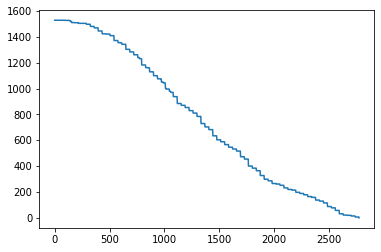

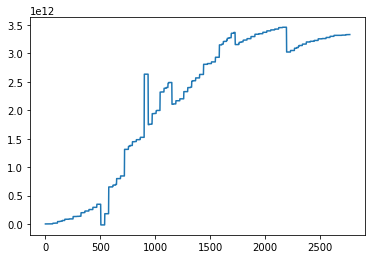

runtime: 435.68798935
Total Revenue: 3331480840607.465


In [43]:
analyse_simulation()

In [44]:
all_port_item

,Pelabuhan,Bobot,Tujuan Pelabuhan
A1,Tanjung Priok,7,Waemulang
A2,Tanjung Perak,1,Saumlaki
A3,Makassar,1,Saumlaki
A4,Namlea,9,Dawera/Dawelor
A5,Namrole,5,P.Geser
A6,Moa,8,Tam
A7,Saumlaki,4,Nila
A8,Kisar,7,Adault/Lingat
A9,Dobo,1,Tual
A10,Ambon,2,P.Manawoka
